### Problem Statement:Predict whether a vehicle requires service given service parameters.


#### The problem is a classification problem as it is based on the decision variable Service
#### Features would be Oil Quality,Engine Performance,NormMileage,TyreWear,HVACWear and label would be Service

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, decomposition, datasets
import warnings
warnings.filterwarnings("ignore")

In [2]:
service_data=pd.read_csv('ServiceTest.csv')
service_data

,OilQual,EnginePerf,NormMileage,TyreWear,HVACwear,Service
0,45.773338,49.936615,49.777581,48.263851,50.952072,No
1,4.987185,7.891003,6.588986,9.493161,3.240262,No
2,4.987185,4.891003,7.308986,8.373161,2.780262,No
3,106.388821,104.454032,103.051485,106.282658,105.536843,No
4,104.388821,103.744032,103.051485,106.132658,105.776843,No
...,...,...,...,...,...,...
130,103.388821,103.934032,102.941485,106.172658,105.536843,No
131,5.987185,6.081003,6.588986,8.373161,0.370262,No
132,25.385516,27.418265,32.309536,30.036162,31.311275,Yes
133,45.533338,49.666615,49.347581,51.263851,47.922072,No


#### Examining the dataset,the data types assigned looks correct

In [3]:
service_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OilQual      135 non-null    float64
 1   EnginePerf   135 non-null    float64
 2   NormMileage  135 non-null    float64
 3   TyreWear     135 non-null    float64
 4   HVACwear     135 non-null    float64
 5   Service      135 non-null    object 
dtypes: float64(5), object(1)
memory usage: 6.5+ KB


In [4]:
service_data.isnull().sum()

OilQual        0
EnginePerf     0
NormMileage    0
TyreWear       0
HVACwear       0
Service        0
dtype: int64

##### There are no null values in the dataset

#### No duplicate records found

In [5]:
duplicate = service_data[service_data.duplicated()] 
len(duplicate)

0

In [6]:
#Imbalanced Dataset
#Ideally should balance dataset and do the classification
service_data['Service'].value_counts(normalize=True)*100

No     73.333333
Yes    26.666667
Name: Service, dtype: float64

#### Percentage of vehicles that require service is 27% and rest 73% does not require service.This means dataset is imbalanced

### Inference 1:The dataset is an imbalanced dataset and hence would be biased.Ideally imbalanced datasets should be corrected by Sampling techniques/SMOTE/XG Boost before doing modeling for a good accuracy.
### Here I used the same imbalanced dataset but used corresponding metrics like F1 Score and AUC Score for determining goodness of model.

In [7]:
service_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OilQual,135.0,58.629380,38.858638,2.597185,26.695516,61.023282,104.228821,106.388821
EnginePerf,135.0,59.077366,38.603943,1.891003,27.418265,61.501061,103.744032,105.744032
NormMileage,135.0,59.118254,37.461473,3.588986,31.259536,59.350883,103.051485,105.051485
TyreWear,135.0,60.863823,38.445306,6.143161,28.901162,61.304031,106.172658,108.172658
HVACwear,135.0,58.986136,40.000363,-1.719738,31.311275,62.620518,105.331843,105.826843


### Inference 2: After checking skewness ,all of the variables have skewness close to zero and hence fairly symmetrical and normally distributed.No outliers.

In [8]:
service_data.skew(axis=0)

OilQual       -0.051592
EnginePerf    -0.127475
NormMileage   -0.088704
TyreWear      -0.025223
HVACwear      -0.146630
dtype: float64

### Inference 3: The correlation matrix shows multicollinearity among all the attributes.when multicollinearity is present in the data,the statistical inferences made about the data may not be reliable.
### To avoid multicollinearity it is good to drop some of the variables while using them for modeling or apply PCA before modeling.PCA reduces/adjusts features in such a way that the resultant features are not correlated

In [9]:
service_data.corr()

,OilQual,EnginePerf,NormMileage,TyreWear,HVACwear
OilQual,1.000000,0.998319,0.997806,0.999025,0.997562
EnginePerf,0.998319,1.000000,0.998801,0.998289,0.998555
NormMileage,0.997806,0.998801,1.000000,0.998180,0.998794
TyreWear,0.999025,0.998289,0.998180,1.000000,0.997291
HVACwear,0.997562,0.998555,0.998794,0.997291,1.000000


#### The pairplot shows the same multicollinearity and distribution.

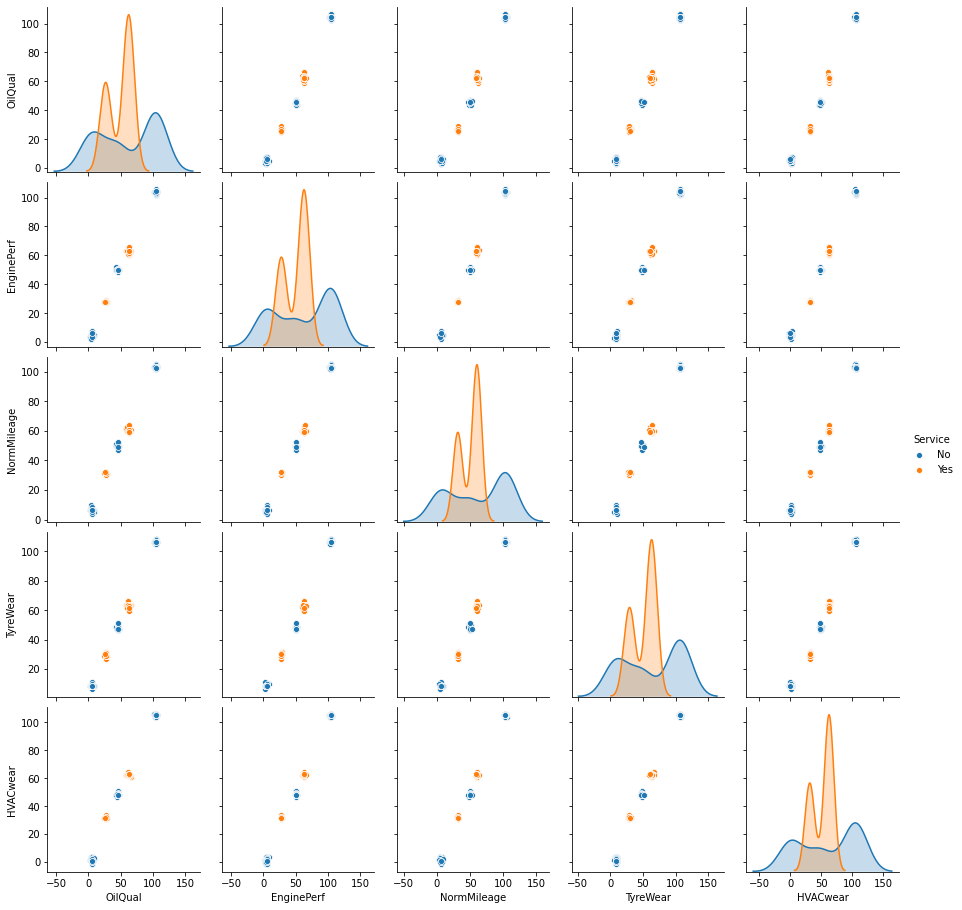

In [10]:
sns.pairplot(service_data,diag_kind='kde',hue='Service')

#### Calculate Variable Inflation Factor(VIF) to confirm multicollinearity.VIF values>5 shows multicollinearity

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [12]:
X = service_data.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,OilQual,1871.133491
1,EnginePerf,2175.801560
2,NormMileage,1952.837485
3,TyreWear,2142.231267
4,HVACwear,1245.953257


#### Highest value of VIF is for EnginePerf

#### Encode categorical variable Service,Requires Service:1(Positive class) and Does not require Service:0(Negative class)

In [13]:
service_data['Service']=service_data['Service'].map({'Yes':1,'No':0})
service_data['Service']

0      0
1      0
2      0
3      0
4      0
      ..
130    0
131    0
132    1
133    0
134    0
Name: Service, Length: 135, dtype: int64

## Classifying the model using Logistic Regression and finding its prediction accuracy,Recall,F1 Score and ROC-AUC metrics

#### Since multicollinearity is present,we can either drop variables and check for accuracy and f1-score(as dataset is imbalanced) and find an ideal combination or use PCA and reduce features in such way that the resultant features are not correlated and then do modeling with Logistic Regression.
#### Here I am using all features,reduce those using PCA,and then applying Logistic Regression.

In [14]:
features=list(service_data.columns)
features.remove('Service')
x=service_data[features].values
y=service_data['Service'].values

##### While making a train,test split to ensure that both classes are represented in the same proportion as in the given dataset use stratify=y argument.This is especially important when classes are imbalanced

In [15]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [16]:
features

['OilQual', 'EnginePerf', 'NormMileage', 'TyreWear', 'HVACwear']

#### FIrst standardize,then do PCA and then Logistic Regression.This can be assigned to a pipeline so that this gets completed together in a stretch.

In [17]:
# Creating an scaler object
std_slc = StandardScaler()

# Creating a pca object
pca = decomposition.PCA(random_state=0)

# Creating a logistic regression object
logistic_Reg = linear_model.LogisticRegression(random_state=0)

In [18]:
# Creating a pipeline of three steps. First, standardizing the data.
# Second, tranforming the data with PCA.
# Third, training a logistic regression on the data.
pipe = Pipeline(steps=[('std_slc', std_slc),('pca', pca),('logistic_Reg', logistic_Reg)])

#### Now we need to find the best parameter values for PCA's ncomponents and Logistic Regression's C and penalty which are used for regularization.
#### This is done using hyperparameter tuning method by using GridSearchCV.
#### GridSearchCV finds the best hyperparameter by applying StratifiedKFold Cross Validation.
#### Here k or number of folds used is 10

In [19]:
# Creating Parameter Space
# Creating a list of a sequence of integers from 1 to 5 (the number of features in train_x + 1)
n_components = list(range(1,train_x.shape[1]+1,1))
penalty = ['l1', 'l2'] # l1 lasso l2 ridge
C = np.logspace(-3,3,7) #penalty values for regularization [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [20]:
grid=dict(pca__n_components=n_components,
        logistic_Reg__C=C,
        logistic_Reg__penalty=penalty)

#### cv refers to number of folds to cross-validate

In [21]:
# Creating a grid search object
clf_GS = GridSearchCV(pipe,grid,cv=10,scoring='roc_auc')

In [22]:
# Fitting the grid search
clf_GS.fit(train_x, train_y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA(random_state=0)),
                                       ('logistic_Reg',
                                        LogisticRegression(random_state=0))]),
             param_grid={'logistic_Reg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logistic_Reg__penalty': ['l1', 'l2'],
                         'pca__n_components': [1, 2, 3, 4, 5]},
             scoring='roc_auc')

In [23]:
# Viewing The Best Parameters
print('Best Penalty:', clf_GS.best_estimator_.get_params())
print("Tuned hyerparameters :(best parameters) ",clf_GS.best_params_)
print("Accuracy :",clf_GS.best_score_)

Best Penalty: {'memory': None, 'steps': [('std_slc', StandardScaler()), ('pca', PCA(n_components=4, random_state=0)), ('logistic_Reg', LogisticRegression(C=1000.0, random_state=0))], 'verbose': False, 'std_slc': StandardScaler(), 'pca': PCA(n_components=4, random_state=0), 'logistic_Reg': LogisticRegression(C=1000.0, random_state=0), 'std_slc__copy': True, 'std_slc__with_mean': True, 'std_slc__with_std': True, 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': 4, 'pca__random_state': 0, 'pca__svd_solver': 'auto', 'pca__tol': 0.0, 'pca__whiten': False, 'logistic_Reg__C': 1000.0, 'logistic_Reg__class_weight': None, 'logistic_Reg__dual': False, 'logistic_Reg__fit_intercept': True, 'logistic_Reg__intercept_scaling': 1, 'logistic_Reg__l1_ratio': None, 'logistic_Reg__max_iter': 100, 'logistic_Reg__multi_class': 'auto', 'logistic_Reg__n_jobs': None, 'logistic_Reg__penalty': 'l2', 'logistic_Reg__random_state': 0, 'logistic_Reg__solver': 'lbfgs', 'logistic_Reg__tol': 0.0001,

#### The best hyperparameters are ncomponents=4 for PCA,C=1000.0 and penalty=l2 for Logistic Regression.Applying those parameters to the pipeline

In [24]:
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=4,random_state=0)), 
                     ('lr1',LogisticRegression(C=1000.0,penalty="l2",random_state=0))])

In [25]:
pipeline_lr.fit(train_x, train_y)

Pipeline(steps=[('scalar1', StandardScaler()),
                ('pca1', PCA(n_components=4, random_state=0)),
                ('lr1', LogisticRegression(C=1000.0, random_state=0))])

In [26]:
print("Accuracy of Logistic Regression model in %:",pipeline_lr.score(test_x, test_y)*100)

Accuracy of Logistic Regression model in %: 90.2439024390244


In [53]:
print("Accuracy of Logistic Regression model in training set %:",pipeline_lr.score(train_x, train_y)*100)

Accuracy of Logistic Regression model in training set %: 90.42553191489363


#### Accuracy of model is 90.24% with optimized hyperparameters
#### But as dataset is imbalanced,accuracy is not the good metric to measure goodness of model

In [27]:
prediction=pipeline_lr.predict(test_x)
prediction

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

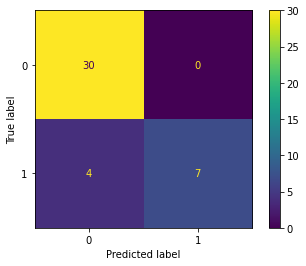

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline_lr, test_x, test_y)  

In [29]:
print('Misclassified samples:%d'%(test_y!=prediction).sum())

Misclassified samples:4


#### For imbalanced data,accuracy is not a good metric to determine goodness of model.
#### F1-Score and ROC AUC Scores are the good metrics.
#### Recall and F1 score should be better in this scenario because if we classify a vehicle that needs service as need not be serviced,it can lead to road accidents.We should minimize False Negatives.Recall is 64% and F1 score is 78% for vehicles that needs service

In [30]:
report=classification_report(test_y,prediction)
print(report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        30
           1       1.00      0.64      0.78        11

    accuracy                           0.90        41
   macro avg       0.94      0.82      0.86        41
weighted avg       0.91      0.90      0.89        41



#### The ROC Curve gives an idea for adjusting threshold.The best value of operating point should be to the top left where Recall will be high and False positive rate would be low.Here for 0.9 Recall and 0.1 FPR,would be the best operating point.
#### ROC curve can be summarized by area under the curve or AUC or ROC AUC Score.

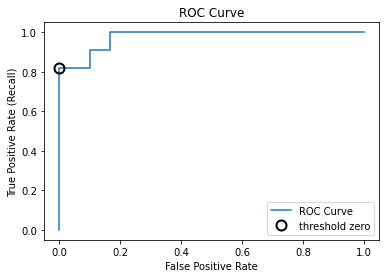

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_y, pipeline_lr.decision_function(test_x))
plt.title("ROC Curve")
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [32]:
from sklearn.metrics import roc_auc_score
print("Logistic Regression ROC AUC Score: ",roc_auc_score(test_y, pipeline_lr.decision_function(test_x) )*100,"%")

Logistic Regression ROC AUC Score:  97.57575757575758 %


#### The model with maximum AUC score would be the best model especially for imbalanced classes.Here AUC Score is 97.57% which is good

## Classifying the model using KNN Algorithm and finding its prediction accuracy

#### KNN is a non-parametric method and hence does not make any assumption about data or its distribution and hence we can proceed directly with the algorithm.
#### Imbalanced dataset again should be balanced by Sampling techniques/SMOTE/XG Boost before doing modeling.
#### Here I used the same imbalanced dataset but used corresponding metrics like F1 Score and AUC Score for determining goodness of model.
#### But as we know there is an inherent multicollinearity in the model,it would be good to apply PCA and then do KNN. Multicollinearity would cause points to be closer in data space and may lead to overfitting


In [33]:
features=list(service_data.columns)
features.remove('Service')
x1=service_data[features].values
y1=service_data['Service'].values

#### The ideal k value should be odd especially when it is a binary classification
#### For imbalanced datasets,stratify=y is used to make the training and test samples representative of the original dataset.

In [34]:
train_x,test_x,train_y,test_y=train_test_split(x1,y1,test_size=0.3,random_state=99,stratify=y)

#### FIrst standardize,then do PCA and then KNN.This can be assigned to a pipeline so that this gets completed together in a stretch.

In [35]:
# Creating an scaler object
std_slc = StandardScaler()

# Creating a pca object
pca = decomposition.PCA(random_state=0)

# Creating a KNN object
KNN_classifier=KNeighborsClassifier()

In [36]:
# Creating a pipeline of three steps. First, standardizing the data.
# Second, tranforming the data with PCA.
# Third, training a logistic regression on the data.
pipe = Pipeline(steps=[('std_slc', std_slc),('pca', pca),('knn', KNN_classifier)])

In [37]:
# Creating Parameter Space
# Creating a list of a sequence of integers from 1 to 5 (the number of features in train_x + 1)
n_components = list(range(1,train_x.shape[1]+1,1))
k_range = list(range(3, 11)) #n_neighbours

#### Now we need to find the best parameter values for PCA's ncomponents and KNN's n_neighbors
#### This is done using hyperparameter tuning method by using GridSearchCV.
#### GridSearchCV finds the best hyperparameter by applying StratifiedKFold Cross Validation.
#### Here k or number of folds used is 10

In [38]:
grid=dict(pca__n_components=n_components,knn__n_neighbors=k_range)

In [39]:
grid

{'pca__n_components': [1, 2, 3, 4, 5],
 'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]}

In [40]:
# Creating a grid search object
knn_GS = GridSearchCV(pipe,grid,cv=10)

In [41]:
# Fitting the grid search
knn_GS.fit(train_x, train_y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA(random_state=0)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10],
                         'pca__n_components': [1, 2, 3, 4, 5]})

In [42]:
# Viewing The Best Parameters
#print('Best Penalty:', knn_GS.best_estimator_.get_params())
print("Tuned hyerparameters :(best parameters) ",knn_GS.best_params_)
print("Accuracy :",knn_GS.best_score_)

Tuned hyerparameters :(best parameters)  {'knn__n_neighbors': 3, 'pca__n_components': 1}
Accuracy : 1.0


#### The best hyperparameters are ncomponents=1 for PCA,n_neighbors=3 for KNN.Applying those parameters to the pipeline

In [43]:
pipeline_knn=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=1,random_state=0)), 
                     ('knn1',KNeighborsClassifier(n_neighbors=3))])

In [44]:
pipeline_knn.fit(train_x, train_y)

Pipeline(steps=[('scalar1', StandardScaler()),
                ('pca1', PCA(n_components=1, random_state=0)),
                ('knn1', KNeighborsClassifier(n_neighbors=3))])

In [45]:
print("Accuracy of KNN model in %:",pipeline_knn.score(test_x, test_y)*100)
prediction=pipeline_knn.predict(test_x)

Accuracy of KNN model in %: 100.0


In [46]:
print("Accuracy of KNN model in training set %:",pipeline_knn.score(train_x, train_y)*100)

Accuracy of KNN model in training set %: 100.0


#### Accuracy of model is 100 % with optimized hyperparameters
#### Hence recall and F1 Score would be 100 % as well.That means no false negatives and false positives

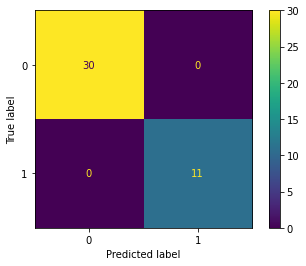

In [47]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline_knn, test_x, test_y)  

In [48]:
report1=classification_report(test_y,prediction)
print(report1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        11

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



In [49]:
print('Misclassified samples:%d'%(test_y!=prediction).sum())

Misclassified samples:0


In [50]:
pipeline_knn.predict_proba(test_x)[:,1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0.])

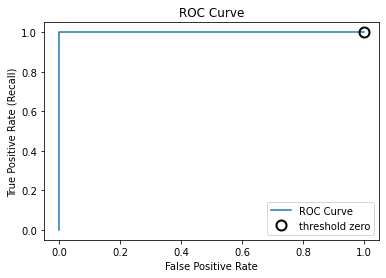

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_y, pipeline_knn.predict_proba(test_x)[:,1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [52]:
from sklearn.metrics import roc_auc_score
print("KNN ROC AUC Score: ",roc_auc_score(test_y, pipeline_knn.predict_proba(test_x)[:,1])*100,"%")

KNN ROC AUC Score:  100.0 %


#### As expected KNN ROC AUC Score is also 100% which shows this does the job perfectly

## Final Inferences
------------------

### After examining Service parameters dataset,
####     1. Dataset is clean and has no duplicates
####     2. Dataset is imbalanced with vehicles requiring service being 27%(positive class) and rest 73%(negative class)
####     3. Features have multicollinearity
####     4. Features follow a near symmetric and normal distribution

### While applying Logistic Regression,techniques used

#### 1. While logistic regression is being used,ideally multicollinearity should be avoided.So for that PCA is used to reduce features in                such a way that resultant features are not correlated and then applied Logistic Regression.
#### 2. For imbalanced data,instead of Accuracy,metrics used are F1-Score and ROC AUC Score.
#### 3. GridSearchCV method is used for hyperparameter tuning of PCA and Logistic Regression with a StratifiedKFold with 10 folds.
#### 4. Data should be standardized before applying PCA.Pipeline is used to apply standardization,PCA and logistic regression


### While applying K Nearest Neighbours,techniques used

#### 1. With KNN also,for avoiding inherent multicollinearity,PCA is used to reduce features in such a way that resultant features are                not correlated and then applied KNN.
#### 2. For imbalanced data,instead of Accuracy,metrics used are F1-Score and ROC AUC Score.
#### 3. GridSearchCV method is used for hyperparameter tuning of PCA and KNN with a StratifiedKFold with 10 folds.
#### 4. Data should be standardized before applying PCA.Pipeline is used to apply standardization,PCA and KNN




### Logistic Regression Metrics after hyperparameter tuning:
-----------------------------------------------------------------------------------

#### 1. Accuracy:90.24%
#### 2. Recall for positive class:64%
#### 3. F1-Score for positive class:78%
#### 4. ROC AUC Score :97.27%



### KNN Metrics after hyperparameter tuning:


#### 1. Accuracy:100%
#### 2. Recall for positive class:100%
#### 3. F1-Score for positive class:100%
#### 4. ROC AUC Score :100%

## Conclusion
 *******************

###   For this particular Service dataset,considering that the dataset is imbalanced and has an inherent multicollinearity-KNN is the best model that gives the best Recall,F1-Score and Area under the Curve(AUC).KNN is applied after reducing the features by PCA .Recall,F1-Score and AUC Score are preferred because we have to avoid/minimize FN(False Negatives).For this particular business scenario FN means predicting a car that 'needs service' as 'do not need service'.That can actually lead to road accidents.